In [72]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os


from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Firstly, we need to read in all training data.

In [27]:
train_dataset = 'dataset/training/' 
test_dataset = 'dataset/testing/'

We now need to preprocess images within each dataset and label them according to their classification.

In [28]:
def preprocess_image(img_path):
    # read in the image
    img = cv2.imread(img_path)

    # convert image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # normalize the data
    img = img / 255

    # resize the image for uniformity
    img = cv2.resize(img, (256, 256))

    return img

In [29]:
label_encoder = LabelEncoder()

def load_data(dataset_path):
    x_data = [] # images
    y_data = [] # labels

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        # check if the path is a directory and skip if not
        if not os.path.isdir(folder_path):
            continue  
        
        for file in os.listdir(folder_path):
            # find path of the image
            file_path = os.path.join(folder_path, file)

            # preprocess the image
            img = preprocess_image(file_path)

            # append the new image to the x array
            x_data.append(img)

            # append the label to the y array
            y_data.append(folder)

    # encode the labels
    y_data = label_encoder.fit_transform(y_data)

    x_data = np.array(x_data)
    y_data = np.array(y_data)

    x_data, y_data = shuffle(x_data, y_data, random_state=8)
    
    return x_data, y_data


In [30]:
x_train, y_train = load_data(train_dataset)
x_test, y_test = load_data(test_dataset)

Now with our data we can choose and create our model.

In [75]:
num_classes = len(np.unique(y_train))

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [76]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy() , 
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In order to test this model we need to get our training data and perform the same preprocessing on the data.

In [85]:
history = model.fit(x_train, y_train, batch_size=16, epochs=5, validation_data=(x_test, y_test))

Epoch 1/3
180/180 [==============================] - 66s 367ms/step - loss: 0.2645 - accuracy: 0.8983 - val_loss: 3.0464 - val_accuracy: 0.6472
Epoch 2/3
180/180 [==============================] - 71s 396ms/step - loss: 0.1777 - accuracy: 0.9376 - val_loss: 3.2837 - val_accuracy: 0.7335
Epoch 3/3
180/180 [==============================] - 70s 389ms/step - loss: 0.1165 - accuracy: 0.9568 - val_loss: 2.6628 - val_accuracy: 0.7462


With this working model, we can evaluate the model and make our observations via the following.

In [55]:
def plot_metrics(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend(['Accuracy', 'Loss'])
    plt.title('Neural Network Performance')
    plt.show()

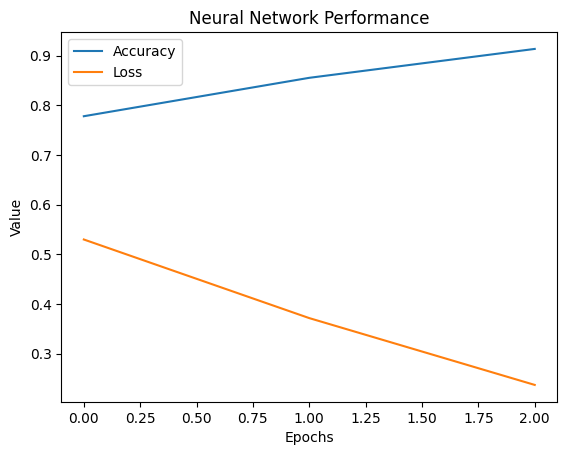

In [81]:
plot_metrics(history)

In [53]:
def plot_confusion_matrix(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    display.plot()

13/13 [==============================] - 2s 182ms/step


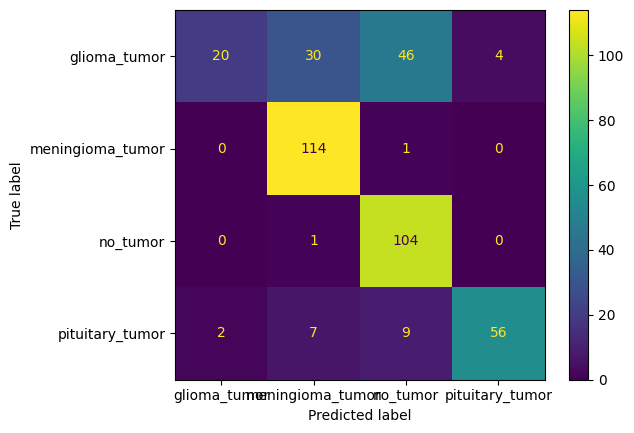

In [86]:
plot_confusion_matrix(model, x_test, y_test)

Finally, we can use our model to make predictions on images outside of our dataset through the following.

In [88]:
def make_prediction(image_path):
    # preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255
    img = cv2.resize(img, (256, 256))

    # reshape the image to match the input shape of the model
    img = np.reshape(img, (1, 256, 256))

    # make the prediction
    prediction = model.predict(img)
    prediction = np.argmax(prediction, axis=1)[0]
    prediction = label_encoder.inverse_transform([prediction])[0]

    print(f'The predicted label is: {prediction}')

In [91]:
make_prediction('dataset/glioma.jpg')

1/1 [==============================] - 0s 39ms/step
The predicted label is: glioma_tumor
